<h1> Материалы курса "Анализ данных в инфромационной безопасности" </h1>

<h2> Практическое занятие № 5.1 </h2>

<h2> Тема: "Классификация спама" </h2>

<h2>Автор:</h2>

<p>Русинова Залина</p>
<p>Младший исследователь исследовательского центра UDV Group</p>
<p>zalina.rusinova@udv.group</p>

In [1]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 5.8 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Оглавление <a name='toc'></a>
<ol>
<li><a href='#load'> Загрузка и подготовка данных</a></li>
<li><a href='#bow'>Bag of Words</a></li>
<li><a href='#tfidf'>Tf-Idf</a></li>
<li><a href='#interp'>Интерпретация</a></li>
</ol>

### 1. Загрузка и подготовка данных <a name='load'></a>

In [3]:
data = pd.read_csv('spam.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

## Предобработка данных

### 1 вариант предобрабоки:

Создадим пайплан обработки данных вручную с использованием библиотек pymorphy2 и nltk:

1. **Токенизация** — самый первый шаг при обработке текста. 
2. **Нормализация** — приведение к одному регистру, удаляются пунктуации, исправление опечаток и т.д.
3. 
    * **Стемминг** —  выделение псевдоосновы слова.
    * **Лемматизация** — приведение слов к словарной ("начальной") форме.
4. **Удаление стоп-слов** — слов, которые не несут никакой смысловой нагрузки (предлоги, союзы и т.п.) Список зависит от задачи!

**Важно!** Не всегда нужны все этапы, все зависит от задачи!

### NLP-библиотеки

NLP-библиотеки для питона:
* Natural Language Toolkit (NLTK)
* Apache OpenNLP
* Stanford NLP suite
* Gate NLP library
* Spacy
* Yargy
* DeepPavlov
* CLTK (для древних языков)
* и т.д.

Самая старая и известная — NLTK. В NLTK есть не только различные инструменты для обработки текста, но и данные — текстовые корпуса, предобученные модели для анализа тональности и морфологической разметки, списки стоп-слов для разных языков и т.п.

* [Учебник по NLTK](https://www.nltk.org/book/) от авторов библиотеки и [тьюториалы](https://github.com/hb20007/hands-on-nltk-tutorial) по решению разных задач NLP с помощью NLTK.
* [Документация Spacy](https://spacy.io/)
* [Документация Yargy](https://yargy.readthedocs.io/)
* [Документация DeepPavlop](http://docs.deeppavlov.ai/)

In [6]:
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

Этап 1 - Нормализация текста. Удаляем пунктуацию и числа, приводим к нижнему регистру

In [7]:
def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

<ins>Удаление стоп-слов</ins>

**Стоп-слова** — высокочастотные слова, которые не дают нам никакой информации о конкретном тексте. Они составляют верхушку частотного списка в любом языке. Набор стоп-слов не универсален, он будет зависеть от вашей задачи!

В NLTK есть готовые списки стоп-слов для многих языков.

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zrusinova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

<ins>Лемматизация</ins>

**Лемматизация** — процесс приведения словоформы к лемме, т.е. нормальной (словарной) форме. Это более сложная задача, чем стемминг, но и результаты дает гораздо более осмысленные, особенно для языков с богатой морфологией.

* кошке, кошку, кошкам, кошкой $\implies$ кошка
* бежал, бежит, бегу $\implies$  бежать
* белому, белым, белыми $\implies$ белый

###  pymorphy2

**pymorphy2** — это полноценный морфологический анализатор, целиком написанный на Python. В отличие от Mystem, он не учитывает контекст, а значит, вопрос разрешения омонимии надо будет решать нам самим (об этом ниже). Он также умеет ставить слова в нужную форму (спрягать и склонять). 

[Документация pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)

In [10]:
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

Собираем пайплайн

In [11]:
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))
lemmas = list(map(clean_text, data['text']))
    
data['cleaned_text'] = lemmas
data.sample(5)

,label,text,cleaned_text
1912,0,For real tho this sucks. I can't even cook my ...,real sucks even cook whole electricity hungry
538,0,Ummmmmaah Many many happy returns of d day my ...,ummmmmaah many many happy returns dear sweet h...
5551,0,Wen did you get so spiritual and deep. That's ...,spiritual deep great
435,0,The message sent is askin for &lt;#&gt; dolla...,message sent askin dollars shoul
1701,0,Can come my room but cannot come my house cos ...,come room cannot come house house still messy ...


### 2 вариант предобрабоки:

Использование готового пайплайна предобработки текста из библиотеки spacy.

**Spacy** - это библиотека расширенной обработки естественного языка (NLP) с открытым исходным кодом на Python. Библиотека spaCy выделяется своей эффективностью и производительностью. Она разработана с акцентом на скорость и точность, что делает ее предпочтительным выбором для многих разработчиков и исследователей в области NLP.

Пайпланы обработки в **spacy** - это последовательность обработки компонентов текста. Пайплан обычно включает в себя теггер, лемматизатор, синтаксический анализатор и распознаватель сущностей. Каждый компонент конвейера возвращает обработанный документ, который затем передается следующему компоненту. 

<img src="https://spacy.io/images/pipeline.svg" alt="pipeline.png" style="width: 600px;"/>

Доспупные компоненты пайплана:

| Название |    Компонент    |   Результат    |           Описание           |
|----------|-----------------|----------------|------------------------------|
|tokenizer |    Tokenizer    |      Doc       |Сегаментирует текст на токены |
|tagger    |     Tagger      |   Token.tag    |Назначает POS-теги            |
|parser    | DependencyParser|   Token.head,  |Назначает лейблы зависимостей |
|          |                 |   Token.dep,   |                              |
|          |                 |   Doc.sents,   |                              |
|          |                 |Doc.noun_chunks |                              |
|ner       | EntityRecognizer|   Doc.ents,    |Размещает именованные сущности|
|          |                 | Token.ent_iob, |                              |
|          |                 | Token.ent_type |                              |
|lemmatizer|   Lemmatizer    |   Token.lemma  |Определяет базовую форму      |
|textcat   | TextCategorizer |   Doc.cats     |Назначает лейблы документа    |
|custom    |custom components|    custom      |Назначает кастомные аттрибуты |

In [12]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"whoever did onto so re we am per fifty such behind too us hereafter doing thus these yourselves full any together elsewhere itself over somehow ’ve to whole here herein being why does neither with almost put once but or thereafter sometimes also quite latterly into and show though rather a everyone get ‘m until take wherein former two ‘s latter between cannot ours seems yourself while hundred whether ’re hereupon please himself before would own n't 'd its her when thence do often noone whither seeming him became except either using every four whenever nobody unless thereupon for themselves ‘ve their others although even thereby across made are towards via well upon myself yet five therefore beside again under meanwhile whereafter amongst make less whereby part whose much already otherwise back give something several our top hence than eleven sixty your else nor done see 'll up wherever all indeed keep them few alone yours above front n‘t beyond say besides bottom below serious some sa

In [13]:
%%time

data['cleaned_text2'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

Wall time: 31.3 s


,label,text,cleaned_text,cleaned_text2
4477,0,I anything lor.,anything,lor
3889,1,Double Mins & 1000 txts on Orange tariffs. Lat...,double mins txts orange tariffs latest motorol...,double mins txt orange tariff late motorola so...
2357,0,Okay same with me. Well thanks for the clarifi...,okay well thanks clarification,okay thank clarification
2695,0,And whenever you and i see we can still hook u...,whenever still hook,hook
5081,0,\HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VI...,babe uawake feellikw shit justfound aletter th...,\hi babe uawake?feellikw shit.justfound alette...


In [14]:
data['cleaned_text2'].iloc[3]

'u dun early hor u c'

### 2. Bag of Words <a name='load'></a>

#### CountVectorizer

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [16]:
print(f'Sklearn english stopwords size: {len(ENGLISH_STOP_WORDS)}', end='\n\n')
' '.join(ENGLISH_STOP_WORDS)

Sklearn english stopwords size: 318



'whoever onto so re we am per fifty such behind too us hereafter thus these yourselves full any together elsewhere itself over somehow etc to whole here herein being why neither eg con with almost put once but or thereafter sometimes system also latterly into and show though rather a everyone get until interest thin take wherein former two latter between cannot ours seems yourself while sincere hundred whether hereupon please himself before would own its her when thence do often noone whither seeming him became except either cant every four whenever nobody thereupon for un themselves their others although even thereby across made are towards via well upon myself yet five therefore beside again under meanwhile whereafter amoungst amongst ie less whereby part whose much already otherwise back give something several inc our top hence than eleven sixty your else nor done see up wherever all indeed bill keep them few alone detail above yours front beyond besides bottom below serious some sa

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [18]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Бейзлайн

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



Логистическая регрессия

In [21]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.96      0.78      0.86       186

    accuracy                           0.97      1393
   macro avg       0.96      0.89      0.92      1393
weighted avg       0.97      0.97      0.96      1393



In [22]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.96      0.78      0.86       186

    accuracy                           0.97      1393
   macro avg       0.96      0.89      0.92      1393
weighted avg       0.97      0.97      0.96      1393



### 3. Tf-Idf <a name='tfidf'></a>

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса


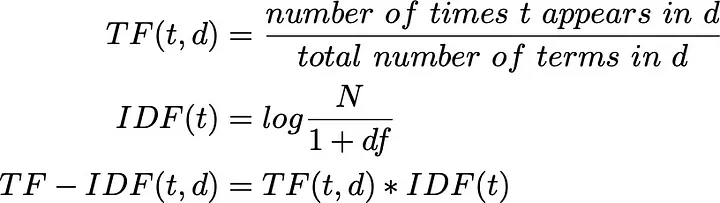

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline

**TfidfTransformer** преобразует матрицу из CountVectorizer в tf-idf

In [24]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1207
           1       0.96      0.66      0.78       186

    accuracy                           0.95      1393
   macro avg       0.96      0.83      0.88      1393
weighted avg       0.95      0.95      0.95      1393



**TfidfVectorizer** работает end-to-end

In [25]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1207
           1       0.96      0.66      0.78       186

    accuracy                           0.95      1393
   macro avg       0.96      0.83      0.88      1393
weighted avg       0.95      0.95      0.95      1393



#### Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

In [26]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

In [27]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [28]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [29]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=2,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 8
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 8
Fitting 2 folds for each of 1600 candidates, totalling 3200 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1760 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C

----------
iter: 1
n_candidates: 534
n_resources: 24
Fitting 2 folds for each of 534 candidates, totalling 1068 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.78787879 0.78787879 0.78787879]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.78787879 0.78787879 0.78787879]
  warnings.warn(


----------
iter: 2
n_candidates: 178
n_resources: 72
Fitting 2 folds for each of 178 candidates, totalling 356 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84563492 0.84563492 0.84563492]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.84563492 0.84563492 0.84563492]
  warnings.warn(


----------
iter: 3
n_candidates: 60
n_resources: 216
Fitting 2 folds for each of 60 candidates, totalling 120 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84185704 0.84185704 0.84185704]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.84185704 0.84185704 0.84185704]
  warnings.warn(


----------
iter: 4
n_candidates: 20
n_resources: 648
Fitting 2 folds for each of 20 candidates, totalling 40 fits


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.85628559 0.85628559 0.86092956]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.85628559 0.85628559 0.87943852]
  warnings.warn(


----------
iter: 5
n_candidates: 7
n_resources: 1944
Fitting 2 folds for each of 7 candidates, totalling 14 fits
Wall time: 15.7 s


C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.86310303 0.86310303 0.90941893]
  warnings.warn(
C:\Users\zrusinova\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.86310303 0.86310303 0.93617956]
  warnings.warn(


HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy', verbose=1)

In [30]:
plt.rcParams["figure.figsize"] = (12, 8)

In [31]:
grid_search.best_score_

0.9094189308887787

In [32]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.96      0.74      0.83       186

    accuracy                           0.96      1393
   macro avg       0.96      0.87      0.91      1393
weighted avg       0.96      0.96      0.96      1393



### 4. Интерпретация <a name='interp'></a>

**SHAP** (аддитивные объяснения Шепли) - это теоретико-игровой подход к объяснению результатов любой модели машинного обучения. Он связывает оптимальное распределение кредитов с локальными объяснениями, используя классические значения Шепли из теории игр и связанные с ними расширения.

In [33]:
!pip install shap

In [34]:
import shap

In [35]:
explainer_line = shap.Explainer(logreg, # модель (не pipeline)
                           X_test_vectorized, # данные (которые подставляются в итоговую модель)
                           feature_names=vectorizer.get_feature_names()
                           # название признаков. чтобы не скучно "feature 1"
                           )
#
shap_values_line = explainer_line(X_test_vectorized)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [36]:
shap_values_line

.values =
array([[ 0.00652949, -0.00997004,  0.00688955, ..., -0.0037091 ,
        -0.00789163,  0.00035962],
       [ 0.00652949, -0.00997004,  0.00688955, ..., -0.0037091 ,
        -0.00789163,  0.00035962],
       [ 0.00652949, -0.00997004,  0.00688955, ..., -0.0037091 ,
        -0.00789163,  0.00035962],
       ...,
       [ 0.00652949, -0.00997004,  0.00688955, ..., -0.0037091 ,
        -0.00789163,  0.00035962],
       [ 0.00652949, -0.00997004,  0.00688955, ..., -0.0037091 ,
        -0.00789163,  0.00035962],
       [ 0.00652949, -0.00997004,  0.00688955, ..., -0.0037091 ,
        -0.00789163,  0.00035962]])

.base_values =
array([-3.12603051, -3.12603051, -3.12603051, ..., -3.12603051,
       -3.12603051, -3.12603051])

.data =
<1393x404 sparse matrix of type '<class 'numpy.int64'>'
	with 4522 stored elements in Compressed Sparse Row format>

Ниже показаны токены, которые сильнее других влияют на предсказание модели

Comparing sparse matrices using == is inefficient, try using != instead.


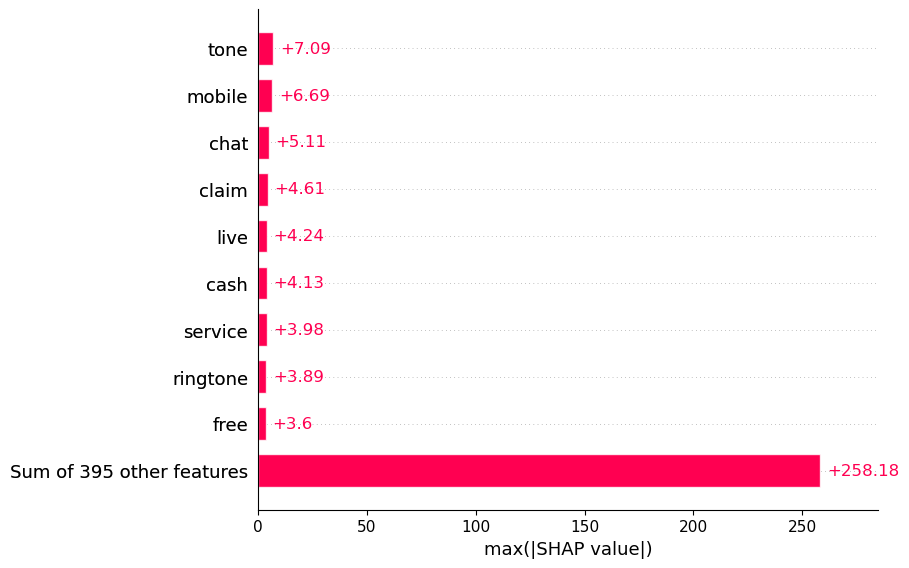

In [37]:
shap.plots.bar(shap_values_line.abs.max(0))

Если мы построим график beeswarm, мы увидим, как влияют токены на результат модели. Токены, которые имеют наибольшую важность модели, в большей степени определяют класс "спам". 

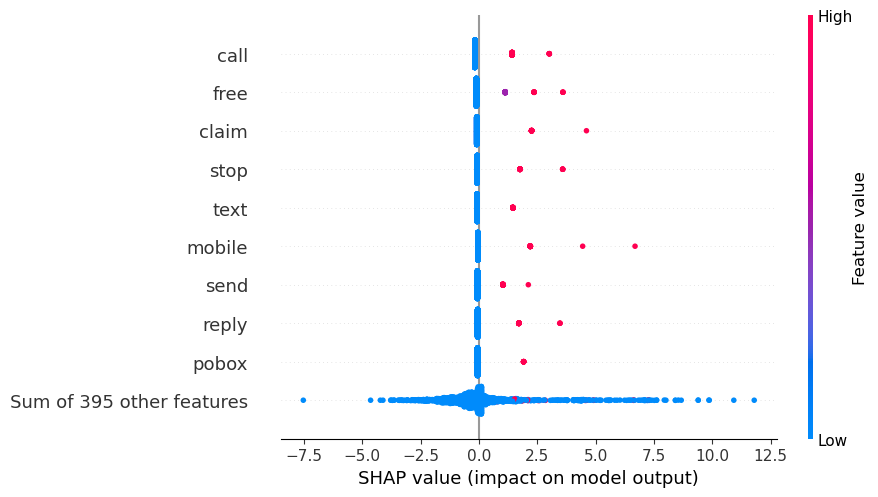

In [38]:
shap.plots.beeswarm(shap_values_line)

Также можно построить локальную область объяснимости для модели. На графике построены результаты для 4 предсказания модели, а также для 100 последующих. Можно видеть, какие токены определяют разные предсказания.

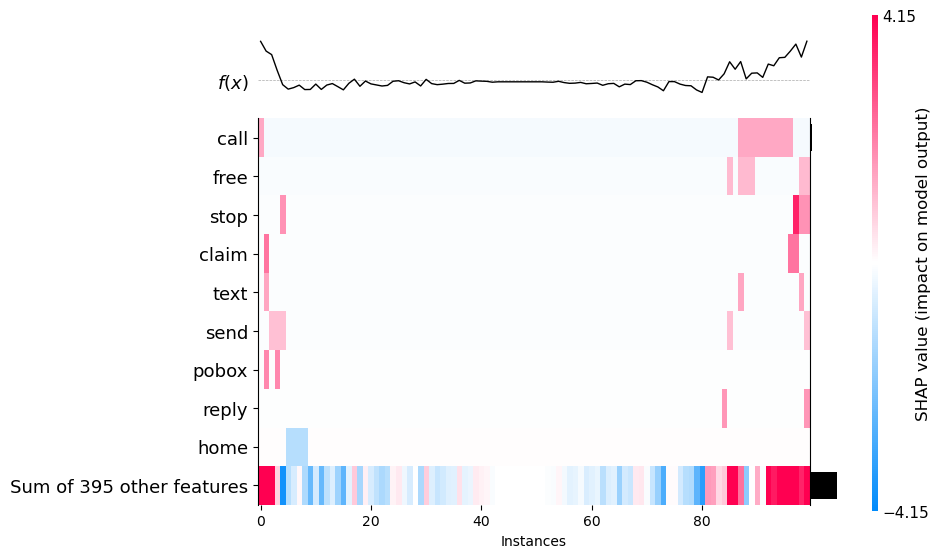

In [39]:
index  = 3

shap.plots.heatmap(shap_values_line[index:index+100])